In [1]:
!pip install transformers torch accelerate matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 19.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 42.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [accelerate]8 [matplotlib]


In [ ]:
from huggingface_hub import login
HF_TOKEN = ""  # replace with your token
login(HF_TOKEN)

/Users/maheswarareddyp/Documents/Courses/Udacity/LLMProfiling/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc
import matplotlib.pyplot as plt

In [14]:
#hf auth login
#model_name = "meta-llama/Llama-3.2-1B"
model_name = "microsoft/Phi-3.5-mini-instruct"
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32 if device != "cpu" else torch.bfloat16

prompt = "The best way to optimze LLM performance is"
generation_lenghts = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

print(f"Using device: {device}, dtype: {dtype}")
if device != "mps":
    print ("Warning: This script is optimized for MPS (Apple Silicon). Performance on CUDA may vary.")

Using device: mps, dtype: torch.float32


In [20]:
import psutil
import os

def get_peak_memory_mb():
    process = psutil.Process(os.getpid())
    mem_bytes = process.memory_info().rss
    return mem_bytes / (1024 * 1024)

    
    
print(f"Loading model and tokenizer for {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype
).to(device)
model.eval()
print("Model and tokenizer loaded.")

peak_memory_results_mb = []

Loading model and tokenizer for microsoft/Phi-3.5-mini-instruct...


Loading weights: 100%|██████████| 195/195 [00:08<00:00, 22.82it/s, Materializing param=model.norm.weight]                              


Model and tokenizer loaded.


In [21]:
# Baseline memory (MPS has no CUDA memory APIs)
if device == "mps":
    torch.mps.synchronize()
    baseline_memory_mb = get_peak_memory_mb()
    print(f"Baseline memory usage: {baseline_memory_mb:.2f} MB")

for length in generation_lenghts:
    print(f"\nGenerating {length} tokens...")
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # MPS does not support reset_peak_memory_stats
    if device == "mps":
        torch.mps.synchronize()

    with torch.no_grad():
        model.generate(
            input_ids,
            max_new_tokens=length,
            use_cache=True,
            pad_token_id=tokenizer.pad_token_id
        )

    if device == "mps":
        torch.mps.synchronize()
        run_peak_memory_mb = get_peak_memory_mb()
        total_peak_memory = baseline_memory_mb + run_peak_memory_mb
        peak_memory_results_mb.append(total_peak_memory)
        print(f"Peak memory usage for {length} tokens: {total_peak_memory:.2f} MB")

    del input_ids

    if device == "mps":
        torch.mps.synchronize()

    gc.collect()


Baseline memory usage: 185.89 MB

Generating 50 tokens...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Peak memory usage for 50 tokens: 527.45 MB

Generating 100 tokens...
Peak memory usage for 100 tokens: 369.25 MB

Generating 150 tokens...
Peak memory usage for 150 tokens: 305.33 MB

Generating 200 tokens...
Peak memory usage for 200 tokens: 287.83 MB

Generating 250 tokens...
Peak memory usage for 250 tokens: 343.16 MB

Generating 300 tokens...
Peak memory usage for 300 tokens: 405.88 MB

Generating 350 tokens...
Peak memory usage for 350 tokens: 981.98 MB

Generating 400 tokens...
Peak memory usage for 400 tokens: 1038.89 MB

Generating 450 tokens...
Peak memory usage for 450 tokens: 1101.78 MB

Generating 500 tokens...
Peak memory usage for 500 tokens: 883.70 MB



Generation complete. Plotting results...
Generarted Tokens  |  Total Peak Memory (MB)
              50  |                  527.45
             100  |                  369.25
             150  |                  305.33
             200  |                  287.83
             250  |                  343.16
             300  |                  405.88
             350  |                  981.98
             400  |                 1038.89
             450  |                 1101.78
             500  |                  883.70

Plot saved as kv_cache_memory_growth.png


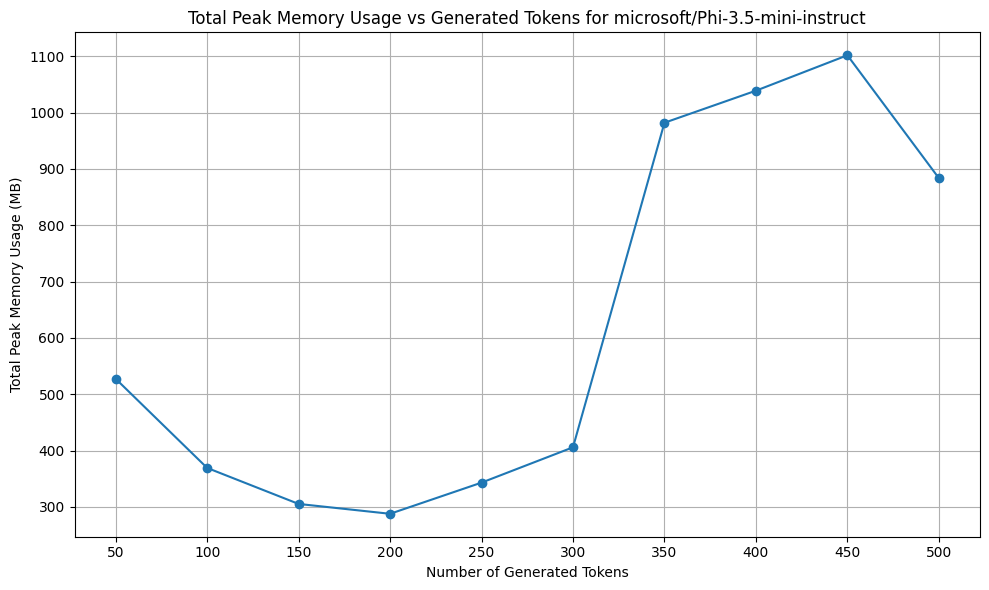

In [26]:
print ("\nGeneration complete. Plotting results...")
print ("Generarted Tokens  |  Total Peak Memory (MB)")
for i, length in enumerate(generation_lenghts):
    mem_val = peak_memory_results_mb[i]
    print(f"{length:16}  |  {mem_val:22.2f}")
    
if device == "mps" and peak_memory_results_mb:
    plt.figure(figsize=(10, 6))
    plt.plot(generation_lenghts, peak_memory_results_mb, marker='o', linestyle='-')
    plt.title(f"Total Peak Memory Usage vs Generated Tokens for {model_name}")
    plt.xlabel("Number of Generated Tokens")
    plt.ylabel("Total Peak Memory Usage (MB)")
    plt.grid(True)
    plt.xticks(generation_lenghts)
    plt.tight_layout()
    plt.savefig("kv_cache_memory_growth.png")   
    print("\nPlot saved as kv_cache_memory_growth.png")
    plt.show()

In [27]:
if len(peak_memory_results_mb) > 1:
    delta_memory = peak_memory_results_mb[-1] - peak_memory_results_mb[0]
    delta_tokens = generation_lenghts[-1] - generation_lenghts[0]
    memory_per_token = delta_memory / delta_tokens
    print(f"\nEstimated memory growth per token: {memory_per_token:.4f} MB/token")


Estimated memory growth per token: 0.7917 MB/token
